# ⏩ 08 - Direct Multi-Step Forecast: Predicting 7-Day Price Horizon

This notebook implements a direct multi-output forecasting approach:

✅ Inputs: Past `x` steps (lags) of features (e.g. solar, wind, load, prices...)
✅ Outputs: Future 168 hours of energy prices (1 week)

We use `MultiOutputRegressor` with `XGBoost` to model this as a multi-target regression problem.

In [1]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load merged dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

## 🧱 Step 1: Build Supervised Dataset
Inputs: past 168 hours of features  
Outputs: next 168 hours of energy price

In [3]:
# Configuration
input_lag = 168  # number of past hours to use
forecast_horizon = 168  # number of hours to predict

# Features to use
feature_cols = [
    'Price (EUR/MWhe)',
    'DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency',
    'Gas_Price', 'Oil_Price', 'DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal', 'DE_temperature'
]

# Generate supervised data
X, y = [], []
for i in range(input_lag, len(df) - forecast_horizon):
    past = df[feature_cols].iloc[i - input_lag:i].values.flatten()
    future = df['Price (EUR/MWhe)'].iloc[i:i + forecast_horizon].values
    X.append(past)
    y.append(future)

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (43442, 1512), y shape: (43442, 168)


## 🧠 Step 2: Train Multi-Output Model

In [4]:
model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 📊 Step 3: Evaluate Forecast Performance

In [5]:
# Evaluate MAE and RMSE over all steps
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 7.53, RMSE: 11.14


## 📈 Step 4: Visualize First Prediction

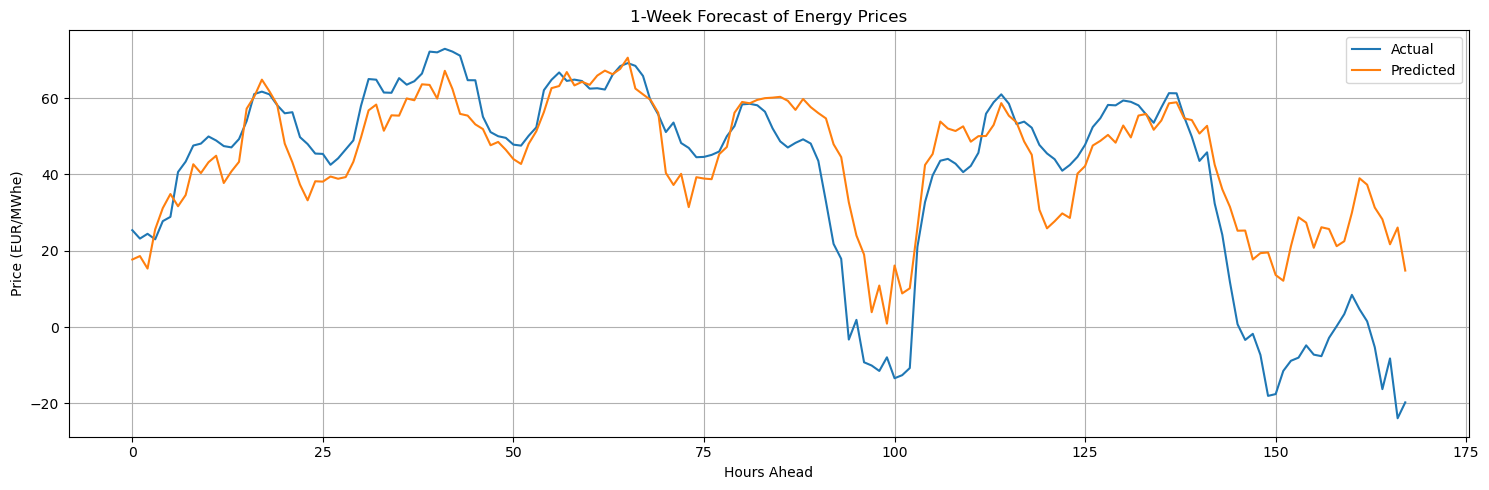

In [6]:
# Plot first prediction vs actual
plt.figure(figsize=(15, 5))
plt.plot(range(forecast_horizon), y_test[0], label='Actual')
plt.plot(range(forecast_horizon), y_pred[0], label='Predicted')
plt.title('1-Week Forecast of Energy Prices')
plt.xlabel('Hours Ahead')
plt.ylabel('Price (EUR/MWhe)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Test model on new data to compare with other models

In [11]:
print(df.columns.tolist())

['cet_cest_timestamp', 'DE_load_actual_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_wind_capacity', 'DE_wind_generation_actual', 'Price (EUR/MWhe)', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal', 'Gas_Price', 'Oil_Price']


In [12]:
feature_cols = [
    'Price (EUR/MWhe)',
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal',
    'DE_temperature'
]

📅 Last available data point: 2019-12-30 00:00:00
📊 MAE: 7.28
📊 RMSE: 8.72


C:\Users\iTECH\AppData\Local\Temp\ipykernel_18824\2361580156.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\iTECH\.julia\conda\3\x86_64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


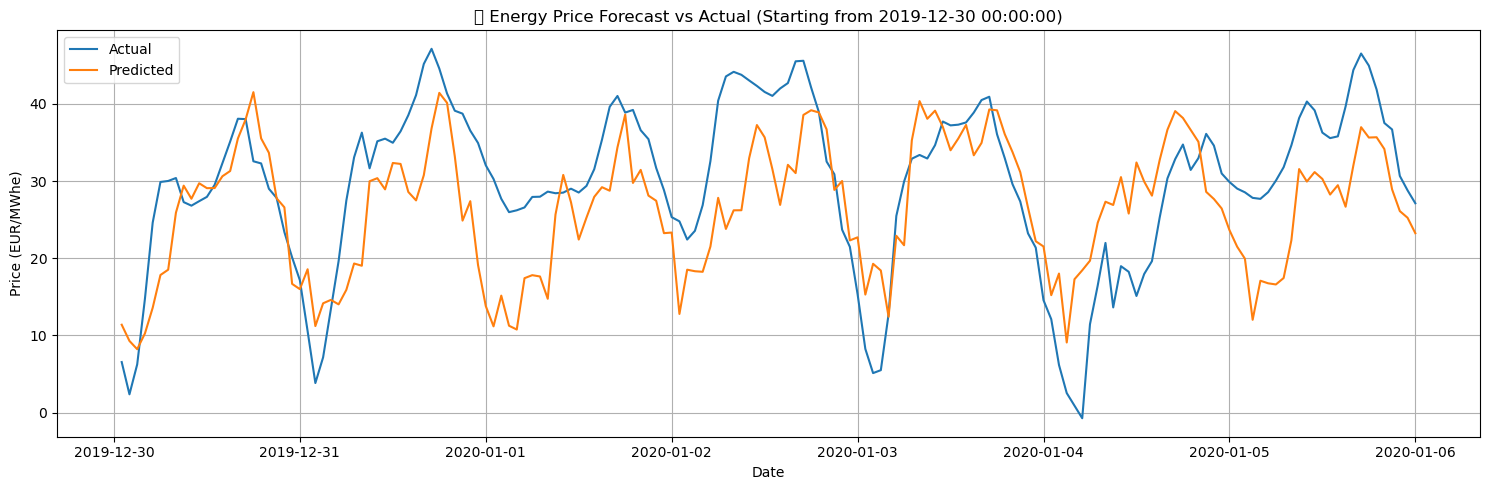

In [13]:
# 🧠 Automatically determine the last available timestamp
last_timestamp = df.index.max()
print("📅 Last available data point:", last_timestamp)

# Use that as the anchor point for your test window
i = df.index.get_loc(last_timestamp)
X_test_final = df[feature_cols].iloc[i - input_lag:i].values.flatten().reshape(1, -1)

# Predict
y_pred_final = model.predict(X_test_final)[0]

# Plot vs actual from Germany.csv for same period
actual_price_final = df_true.loc[last_timestamp + pd.Timedelta(hours=1):last_timestamp + pd.Timedelta(hours=forecast_horizon), 'Price (EUR/MWhe)']

# Evaluate and plot
mae = mean_absolute_error(actual_price_final.values, y_pred_final[:len(actual_price_final)])
rmse = np.sqrt(np.mean((actual_price_final.values - y_pred_final[:len(actual_price_final)])**2))

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")

plt.figure(figsize=(15, 5))
plt.plot(actual_price_final.index, actual_price_final.values, label='Actual')
plt.plot(actual_price_final.index, y_pred_final[:len(actual_price_final)], label='Predicted')
plt.title(f"📈 Energy Price Forecast vs Actual (Starting from {last_timestamp})")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()


Tried a very computationally expensive model to see if it works better. The input x was all the features and their history for 168 hours in the past. The output was 168 data points representing the price of energy at time t+1 to t+168. Results show that the method in notebook 04 is still better </br>
Finished by Jad Akra on Friday 19th of April 2025